In [1]:
import sys
import os
import numpy as np
import napari
%matplotlib inline
from matplotlib import pyplot as plt  # graphic library, for plots
import seaborn as sns

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure, show
from bokeh.sampledata.stocks import AAPL

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
import filedialogs

In [4]:
from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io import EventsIterator

In [5]:
path = filedialogs.gui_fname('example_data/')
path = path.decode('ascii')

In [6]:
record_raw = RawReader(path)
print(record_raw)

RawReader(C:/Users/B0067-WS-2/Documents/code/github-ffvoigt/accordion/playground/example_data/fish_bouts_recording_2023-06-27_10-42-58.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 10000000


In [7]:
events = record_raw.load_n_events(1000000)
print(events)

[(834, 596, 1,     8214) (925,   4, 0,     9194) (767, 127, 0,     9410)
 ... (829, 542, 0, 15191063) (771, 162, 0, 15191064)
 (810, 484, 0, 15191067)]


In [12]:
events['t'].max()

15191067

In [28]:
def calculate_bins(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    interval_us = max_timepoint-min_timepoint
    timepoints = int(interval_us / (dt))
    bins = np.linspace(min_timepoint, max_timepoint, timepoints)
    return bins

def calculate_bin_number(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    timepoints = int(np.floor((max_timepoint-min_timepoint) / (dt)))
    return timepoints

In [78]:
bins = calculate_bin_number(events, dt=250)

In [68]:
bins

7591

In [25]:
len(events)

236083

In [39]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

In [79]:
hist, edges = np.histogram(events['t'], density=False, bins=bins)

In [70]:
hist[0:10]

array([ 3,  4,  1,  4,  5,  0,  3, 10,  3,  0], dtype=int64)

In [81]:

source = ColumnDataSource(data=dict(edges=edges[:-1], hist=hist))

p = figure(height=400, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(edges[5000], edges[5500]))

p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue")
p.y_range.start = 0
p.xaxis.axis_label = "t (us)"
p.yaxis.axis_label = "Events"

select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('edges', 'hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(p, select))

In [66]:
p.x_range

Range1d(id='p1924', ...)

In [8]:
rng = np.random.default_rng()
x = rng.normal(loc=0, scale=1, size=10000)

p = figure(width=670, height=400, toolbar_location=None,
           title="Normal (Gaussian) Distribution")

# Histogram
bins = np.linspace(-3, 3, 40)
hist, edges = np.histogram(x, density=True, bins=bins)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white",
         legend_label="1000 random samples")

# Probability density function
# x = np.linspace(-3.0, 3.0, 100)
# pdf = np.exp(-0.5*x**2) / np.sqrt(2.0*np.pi)
#p.line(x, pdf, line_width=2, line_color="navy",
#       legend_label="Probability Density Function")

p.y_range.start = 0
p.xaxis.axis_label = "x"
p.yaxis.axis_label = "PDF(x)"

show(p)

In [ ]:
events['p']

In [ ]:
len(events['t'])

In [ ]:
type(events[4])

In [ ]:
events2 = np.array([[events['t'], events['x'], events['y'], events['p']]])
events2 = np.array([[events['t'], events['x'], events['y']]])

In [ ]:
events[3][1]

In [ ]:
print(events[2])
print(np.roll(events[2],2))

In [ ]:
type(events2)

In [ ]:
events2.shape

In [ ]:
events2

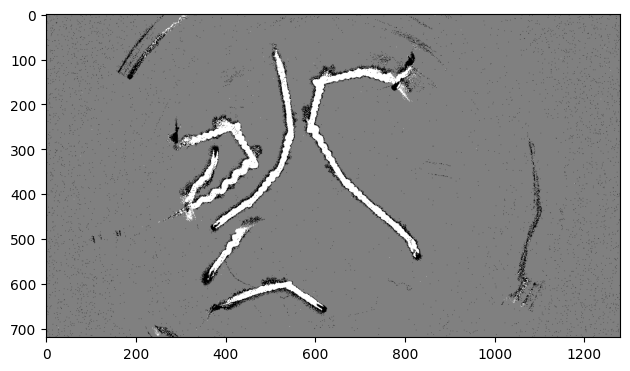

In [40]:
height, width = record_raw.get_size()

# load the next 50 ms worth of events
# events = record_raw.load_delta_t(50000)
im = viz_events(events, height, width)

plt.imshow(im)
plt.tight_layout()

In [ ]:
plt.hist(events['t'], bins=1000)

In [ ]:
intereventintervals = np.diff(events['t'])

In [ ]:
plt.hist(intereventintervals, bins=50, range=(0,50))

### Numpy arrays have names for columns!

In [ ]:
events.dtype.names

### Napari plot

In [ ]:
from skimage import data

In [ ]:
viewer = napari.Viewer()

In [ ]:
points = np.array([[1, 100, 100, 2], [2, 200, 200, 4], [3, 300, 100, 4]])

In [ ]:
points_layer = viewer.add_points(events[:10000], size=2)

In [ ]:
record_raw.get_size()